Install MMSegmentation

https://github.com/open-mmlab/mmsegmentation/blob/main/docs/en/get_started.md#installation

Showing the original image example

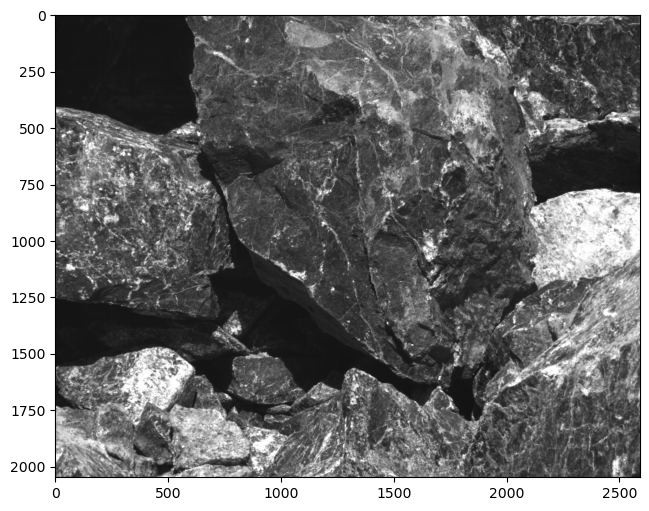

In [5]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

test_image = '14-40-42_11_2_9'


img = mmcv.imread('asbestos/images/'+test_image+'.bmp')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Loading the dataset

In [6]:
from asbestos import AsbestosDataset

data_root = 'asbestos'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
#classes = ('asbestos', 'stone', 'background')
#palette = [[146, 17, 162], [112, 128, 0], [0, 0, 0]]

#classes = ('background', 'stone', 'asbestos')
#palette = [[15,15,15],[112, 128, 0],[146, 17, 162]]

#classes = ('background', 'asbestos')
#palette = [[15, 15, 15], [146, 17, 162]]

classes = ('background', 'stone', 'asbestos')
palette = [[15,15,15],[112, 128, 0],[146, 17, 162]]

In [7]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
#for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#  seg_img = Image.fromarray(seg_map).convert('P')
#  seg_img.putpalette(np.array(palette, dtype=np.uint8))
#  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                         '.png')))

Show the segmentation map for test image

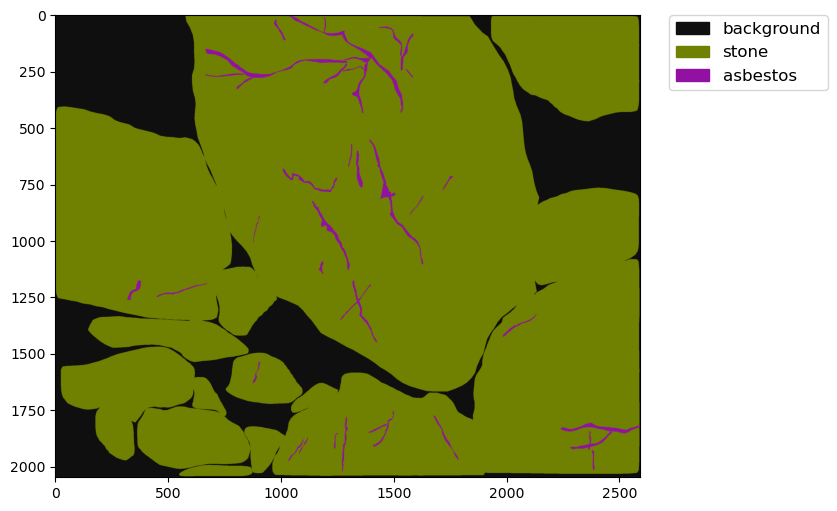

In [8]:
import matplotlib.patches as mpatches
img = Image.open('asbestos/labels/'+test_image+'.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(palette))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

Splitting the dataset into a train and validation subsets

In [9]:
import random

# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

random.shuffle(filename_list)

# select first 4/5 as train set
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])

# select last 1/5 as train set
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list[train_length:])

Downloading the model and loading the config

In [10]:
!mim download mmsegmentation --config unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024 --dest .

In [11]:
from mmengine import Config

cfg = Config.fromfile('unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py')

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='SyncBN', requires_grad

Modifying the config

In [12]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (512, 1024)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
#cfg.model.decode_head.loss_decode=dict(
#    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[1.0, 1.0, 55.0])

cfg.model.decode_head.loss_decode=[
        dict(type='CrossEntropyLoss', use_sigmoid=False, loss_name='loss_ce', loss_weight=1.0, class_weight=[1.0, 1.0, 55.0], avg_non_ignore=True),
        dict(type='DiceLoss', loss_name='loss_dice', loss_weight=3.0)
    ]

#cfg.model.decode_head.loss_decode=dict(
#    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[1.0, 1.0, 15])
                                                                            #[0.1, 1.0, 10.0])    
#cfg.model.auxiliary_head.loss_decode=dict(
#    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[1.0, 1.0, 10.0])
#cfg.model.decode_head.threshold = 0.50
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'AsbestosDataset'
cfg.data_root = data_root
#cfg.reduce_zero_label=True
#cfg.class_weight = [1.0, 10.0]

cfg.train_dataloader.batch_size = 4
#cfg.train_dataloader.num_workers = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(2592, 2048), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2592, 2048), keep_ratio=True),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

#cfg.val_dataloader.num_workers = cfg.train_dataloader.num_workers
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.num_workers = cfg.train_dataloader.num_workers

# Load the pretrained weights
cfg.load_from = 'fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth'
#cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
#cfg.load_from = 'fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed'

#cfg.load_from = 'mask2former_r50_8xb2-90k_cityscapes-512x1024_20221202_140802-ffd9d750.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs_unet/test'

cfg.train_cfg.max_iters = 16000
cfg.train_cfg.val_interval = 1000
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000


cfg.val_evaluator = dict(ignore_index=0, type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])
cfg.test_evaluator  = dict(ignore_index=0, type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),


Train

In [13]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

12/06 11:36:11 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 4090
    CUDA_HOME: D:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 1.13.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;ar

12/06 11:36:14 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/06 11:36:14 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

d:\work15\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
d:\work15\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
d:\work15\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [14]:
# start training
runner.train()

12/06 11:36:18 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 64, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
12/06 11:36:19 - mmengine - INFO - Load checkpoint from fcn_unet_s5-d16_4x4_51

12/06 11:52:21 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:07  time: 0.3536  data_time: 0.0047  memory: 11857  
12/06 11:52:28 - mmengine - INFO - per class results:
12/06 11:52:28 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------+
|   Class    |  IoU  |  Acc  |  Dice | Fscore | Precision | Recall |
+------------+-------+-------+-------+--------+-----------+--------+
| background |  0.0  |  nan  |  0.0  |  nan   |    0.0    |  nan   |
|   stone    | 30.62 |  30.7 | 46.88 | 46.88  |   99.14   |  30.7  |
|  asbestos  |  2.08 | 81.74 |  4.07 |  4.07  |    2.09   | 81.74  |
+------------+-------+-------+-------+--------+-----------+--------+
12/06 11:52:28 - mmengine - INFO - Iter(val) [122/122]    aAcc: 31.4800  mIoU: 10.9000  mAcc: 56.2200  mDice: 16.9800  mFscore: 25.4800  mPrecision: 33.7400  mRecall: 56.2200  data_time: 0.0056  time: 0.3536
12/06 11:53:12 - mmengine - INFO - Iter(train) [ 2100/16000]  lr: 9.8830e-03  eta: 1:41:04  time: 

12/06 12:08:27 - mmengine - INFO - Iter(val) [122/122]    aAcc: 84.1400  mIoU: 28.0500  mAcc: 42.7200  mDice: 30.4700  mFscore: 91.4000  mPrecision: 49.1300  mRecall: 42.7200  data_time: 0.0054  time: 0.3643
12/06 12:09:10 - mmengine - INFO - Iter(train) [ 4100/16000]  lr: 9.7714e-03  eta: 1:26:19  time: 0.4369  data_time: 0.0033  memory: 16995  loss: 3.2683  decode.loss_ce: 1.6695  decode.loss_dice: 1.3023  decode.acc_seg: 19.7435  aux.loss_ce: 0.2965  aux.acc_seg: 58.1671
12/06 12:09:54 - mmengine - INFO - Iter(train) [ 4200/16000]  lr: 9.7659e-03  eta: 1:25:35  time: 0.4279  data_time: 0.0032  memory: 16995  loss: 3.3579  decode.loss_ce: 1.9235  decode.loss_dice: 1.1317  decode.acc_seg: 61.5582  aux.loss_ce: 0.3028  aux.acc_seg: 66.3127
12/06 12:10:38 - mmengine - INFO - Iter(train) [ 4300/16000]  lr: 9.7603e-03  eta: 1:24:53  time: 0.4359  data_time: 0.0032  memory: 16995  loss: 4.0954  decode.loss_ce: 2.5580  decode.loss_dice: 1.2160  decode.acc_seg: 26.4073  aux.loss_ce: 0.3214  

12/06 12:26:38 - mmengine - INFO - Iter(train) [ 6300/16000]  lr: 9.6485e-03  eta: 1:10:20  time: 0.4291  data_time: 0.0032  memory: 16995  loss: 2.8773  decode.loss_ce: 1.3943  decode.loss_dice: 1.2076  decode.acc_seg: 56.6570  aux.loss_ce: 0.2754  aux.acc_seg: 63.3227
12/06 12:27:21 - mmengine - INFO - Iter(train) [ 6400/16000]  lr: 9.6429e-03  eta: 1:09:37  time: 0.4337  data_time: 0.0033  memory: 16995  loss: 3.0856  decode.loss_ce: 1.6333  decode.loss_dice: 1.1652  decode.acc_seg: 56.0750  aux.loss_ce: 0.2870  aux.acc_seg: 68.8113
12/06 12:28:05 - mmengine - INFO - Iter(train) [ 6500/16000]  lr: 9.6373e-03  eta: 1:08:53  time: 0.4413  data_time: 0.0033  memory: 16995  loss: 3.6986  decode.loss_ce: 2.1769  decode.loss_dice: 1.2189  decode.acc_seg: 28.9071  aux.loss_ce: 0.3029  aux.acc_seg: 63.3118
12/06 12:28:48 - mmengine - INFO - Iter(train) [ 6600/16000]  lr: 9.6317e-03  eta: 1:08:10  time: 0.4448  data_time: 0.0033  memory: 16995  loss: 2.8887  decode.loss_ce: 1.5090  decode.lo

12/06 12:44:30 - mmengine - INFO - Iter(train) [ 8600/16000]  lr: 9.5198e-03  eta: 0:53:25  time: 0.4241  data_time: 0.0041  memory: 16995  loss: 3.2396  decode.loss_ce: 1.8318  decode.loss_dice: 1.1265  decode.acc_seg: 49.6697  aux.loss_ce: 0.2813  aux.acc_seg: 51.8892
12/06 12:45:12 - mmengine - INFO - Iter(train) [ 8700/16000]  lr: 9.5142e-03  eta: 0:52:41  time: 0.4240  data_time: 0.0030  memory: 16995  loss: 3.4265  decode.loss_ce: 1.8904  decode.loss_dice: 1.2358  decode.acc_seg: 35.3424  aux.loss_ce: 0.3003  aux.acc_seg: 59.3166
12/06 12:45:55 - mmengine - INFO - Iter(train) [ 8800/16000]  lr: 9.5086e-03  eta: 0:51:57  time: 0.4239  data_time: 0.0037  memory: 16995  loss: 5.2200  decode.loss_ce: 3.8586  decode.loss_dice: 1.0417  decode.acc_seg: 57.7580  aux.loss_ce: 0.3197  aux.acc_seg: 65.7636
12/06 12:46:37 - mmengine - INFO - Iter(train) [ 8900/16000]  lr: 9.5030e-03  eta: 0:51:13  time: 0.4241  data_time: 0.0032  memory: 16995  loss: 3.9447  decode.loss_ce: 2.4114  decode.lo

12/06 13:02:10 - mmengine - INFO - Iter(train) [10900/16000]  lr: 9.3909e-03  eta: 0:36:38  time: 0.4192  data_time: 0.0025  memory: 16995  loss: 2.7994  decode.loss_ce: 1.3960  decode.loss_dice: 1.1346  decode.acc_seg: 58.7346  aux.loss_ce: 0.2688  aux.acc_seg: 75.1384
12/06 13:02:52 - mmengine - INFO - Exp name: unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024_20231206_113607
12/06 13:02:52 - mmengine - INFO - Iter(train) [11000/16000]  lr: 9.3853e-03  eta: 0:35:54  time: 0.4219  data_time: 0.0036  memory: 16995  loss: 3.4064  decode.loss_ce: 1.8945  decode.loss_dice: 1.2122  decode.acc_seg: 42.8898  aux.loss_ce: 0.2998  aux.acc_seg: 71.9302
12/06 13:02:52 - mmengine - INFO - Saving checkpoint at 11000 iterations
12/06 13:03:28 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:07  time: 0.3491  data_time: 0.0056  memory: 11857  
12/06 13:03:36 - mmengine - INFO - per class results:
12/06 13:03:36 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------

12/06 13:18:22 - mmengine - INFO - Saving checkpoint at 13000 iterations
12/06 13:18:58 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:07  time: 0.3445  data_time: 0.0048  memory: 11857  
12/06 13:19:05 - mmengine - INFO - per class results:
12/06 13:19:05 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------+
|   Class    |  IoU  |  Acc  |  Dice | Fscore | Precision | Recall |
+------------+-------+-------+-------+--------+-----------+--------+
| background |  0.0  |  nan  |  0.0  |  nan   |    0.0    |  nan   |
|   stone    | 41.53 | 41.74 | 58.68 | 58.68  |   98.75   | 41.74  |
|  asbestos  |  2.27 | 63.75 |  4.43 |  4.43  |    2.3    | 63.75  |
+------------+-------+-------+-------+--------+-----------+--------+
12/06 13:19:05 - mmengine - INFO - Iter(val) [122/122]    aAcc: 42.0800  mIoU: 14.6000  mAcc: 52.7500  mDice: 21.0400  mFscore: 31.5600  mPrecision: 33.6800  mRecall: 52.7500  data_time: 0.0051  time: 0.3477
12/06 13:19:47 - mmengine

12/06 13:34:35 - mmengine - INFO - Iter(val) [122/122]    aAcc: 49.6300  mIoU: 17.4600  mAcc: 62.6700  mDice: 24.0800  mFscore: 36.1200  mPrecision: 34.2200  mRecall: 62.6700  data_time: 0.0052  time: 0.3489
12/06 13:35:17 - mmengine - INFO - Iter(train) [15100/16000]  lr: 9.1551e-03  eta: 0:06:25  time: 0.4219  data_time: 0.0031  memory: 16995  loss: 2.9396  decode.loss_ce: 1.5245  decode.loss_dice: 1.1302  decode.acc_seg: 50.7944  aux.loss_ce: 0.2849  aux.acc_seg: 67.7980
12/06 13:35:59 - mmengine - INFO - Iter(train) [15200/16000]  lr: 9.1494e-03  eta: 0:05:42  time: 0.4201  data_time: 0.0042  memory: 16995  loss: 3.3050  decode.loss_ce: 1.8507  decode.loss_dice: 1.1646  decode.acc_seg: 31.9696  aux.loss_ce: 0.2896  aux.acc_seg: 44.1039
12/06 13:36:41 - mmengine - INFO - Iter(train) [15300/16000]  lr: 9.1438e-03  eta: 0:04:59  time: 0.4214  data_time: 0.0031  memory: 16995  loss: 2.9080  decode.loss_ce: 1.4692  decode.loss_dice: 1.1543  decode.acc_seg: 52.1867  aux.loss_ce: 0.2845  

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): UNet(
    (encoder): ModuleList(
      (0): Sequential(
        (0): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
              (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
            (1): ConvModule(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
          )
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
    

Inference with trained model

In [17]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs_unet/test/iter_9000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs_unet/test/iter_9000.pth


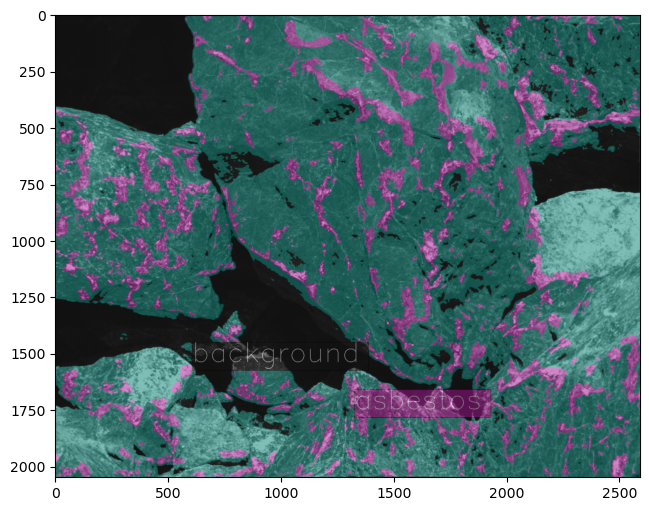

In [18]:
img = mmcv.imread('asbestos/images/'+test_image+'.bmp')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result,out_file='work_dirs_unet/'+test_image+'.png',show=False)
plt.imshow(mmcv.bgr2rgb(vis_result))